## Reseña numérica y computacional

Material complementario al capítulo 2.

### Implementación con NumPy

In [20]:
import numpy as np

def laplacian2(X):
    Xn = X.copy()
    Xn[1:-1,1:-1] = X[1:-1,2:] + X[1:-1,0:-2] + X[2:,1:-1] + X[0:-2,1:-1] - 4*X[1:-1,1:-1]
    
    Xn[0,1:-1] = X[1,1:-1] + X[-1,1:-1] + X[0,2:] + X[0,0:-2] - 4*X[0,1:-1]
    Xn[-1,1:-1] = X[0,1:-1] + X[-2,1:-1] + X[-1,2:] + X[-1,0:-2] - 4*X[-1,1:-1]
    Xn[1:-1,0] = X[1:-1,1] + X[1:-1,-1] + X[2:,0] + X[0:-2,0] - 4*X[1:-1,0]
    Xn[1:-1,-1] = X[1:-1,0] + X[1:-1,-2] + X[2:, -1] + X[0:-2, -1] - 4*X[1:-1,-1]
    
    Xn[0,0] = X[1,0] + X[-1,0] + X[0,1] + X[0,-1] - 4*X[0,0]
    Xn[0,-1] = X[1,-1] + X[-1,-1] + X[0,0] + X[0,-2] - 4*X[0,-1]
    Xn[-1,0] = X[0,0] + X[-2,0] + X[-1,1] + X[-1,-1] - 4*X[-1,0]
    Xn[-1,-1] = X[0,-1] + X[-2,-1] + X[-1,0] + X[-1,-2] - 4*X[-1,-1]
    return Xn

def laplacian(X):
    '''
    Take the Laplacian of a 2D array with periodic boundury conditions.
    '''
    return np.roll(X,1,axis = 0) + np.roll(X,-1,axis = 0) + np.roll(X,1,axis = 1) + np.roll(X,-1,axis = 1) - 4*X

def cpu_numpy_solver(u, v, fu, fv, Ds, dt = .01, d = 1, it = 1000):
    '''
    Solve a 2D reaction-diffusion equation for two dynamical variables with periodic boundary conditions using NumPy.

    u: Intial conditions for the first dynamical variable. 2d NumPy array of shape (Ly,Lx).
    v: Intial conditions for the second dynamical variable. 2d NumPy array of shape (Ly,Lx).
    f1: Reaction term for the first dynamical variable. Function.
    f2: Reaction term for the second dynamical variable. Function.
    Ds: Diffusion coefficients for the first and second dynamical variables. List or array of length 2.
    dt: Time step. Default value is 0.01.
    d: Space step. Default value is 1.
    it: Number of iterations. Default value is 1000.
    '''
    
    #Error checking
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")

    if len(Ds) != 2:
        raise ValueError("Ds must be a list or array of length 2.")
    
    Du,Dv = Ds
    for _ in range(it):
        u = u + dt*(fu(u,v) + Du*laplacian2(u)/d**2)
        v = v + dt*(fv(u,v) + Dv*laplacian2(v)/d**2)
    return u,v


In [60]:
import cupy as cp
import numpy as np

def cupy_laplacian2(X):
    Xn = X.copy()
    Xn[1:-1,1:-1] = X[1:-1,2:] + X[1:-1,0:-2] + X[2:,1:-1] + X[0:-2,1:-1] - 4*X[1:-1,1:-1]
    
    Xn[0,1:-1] = X[1,1:-1] + X[-1,1:-1] + X[0,2:] + X[0,0:-2] - 4*X[0,1:-1]
    Xn[-1,1:-1] = X[0,1:-1] + X[-2,1:-1] + X[-1,2:] + X[-1,0:-2] - 4*X[-1,1:-1]
    Xn[1:-1,0] = X[1:-1,1] + X[1:-1,-1] + X[2:,0] + X[0:-2,0] - 4*X[1:-1,0]
    Xn[1:-1,-1] = X[1:-1,0] + X[1:-1,-2] + X[2:, -1] + X[0:-2, -1] - 4*X[1:-1,-1]
    
    Xn[0,0] = X[1,0] + X[-1,0] + X[0,1] + X[0,-1] - 4*X[0,0]
    Xn[0,-1] = X[1,-1] + X[-1,-1] + X[0,0] + X[0,-2] - 4*X[0,-1]
    Xn[-1,0] = X[0,0] + X[-2,0] + X[-1,1] + X[-1,-1] - 4*X[-1,0]
    Xn[-1,-1] = X[0,-1] + X[-2,-1] + X[-1,0] + X[-1,-2] - 4*X[-1,-1]
    return Xn

laplace = cp.ElementwiseKernel('raw float64 X, uint32 Lx, uint32 Ly', 'float64 Y',
'''
int x = i % Lx;
int y = (int) i / Lx;

Y = X[(x+1)%Lx + Lx*y] + X[(x-1+Lx)%Lx + Lx*y] + X[x + Lx*((y+1)%Ly)] + X[x + Lx*((y-1+Ly)%Ly)] - 4*X[i]

''' ,'lapalce')

@cp.fuse()
def cupy_solver(u, v, fu, fv, Ds, dt = .01, d = 1, it = 1000):

    Du,Dv = Ds
    for _ in range(it):
        u = u + dt*(fu(u,v) + Du*laplace(u,1024,1024,size=1024*1024).reshape((1024,1024))/d**2)
        v = v + dt*(fv(u,v) + Dv*laplace(v,1024,1024,size=1024*1024).reshape((1024,1024))/d**2)
    return u,v

def euler(x,y,f,dt,D,d):
    return x + dt*(f(x,y) + D*cupy_laplacian2(x)/d**2)

@cp.fuse()
def fu(u,v):
    return -beta*u*v
@cp.fuse()
def fv(u,v):
    return beta*u*v - gamma*v

In [77]:
def test(u,v,f):
    
    cp.fuse()
    def f_fuse(u,v):
        return f(u,v)
     
    return f_fuse

In [87]:
fu(u,u)

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [88]:
fu_fuse(u,u)

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [80]:
fu_fuse = test(u,u,fu)

In [69]:
u = cp.zeros((L,L))
laplace(u,L,L,size=L*L).reshape((L,L))
test(u,u,fu)

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [62]:
L = 1024
beta = 1.
gamma = .2
u = cp.ones((L,L))
v = cp.zeros((L,L))
u[:,0] = 0
v[:,0] = 1.
Ds = [0,1]

uf,vf = cupy_solver(u,v,fu,fv,Ds)

TypeError: Unsupported type <class 'numpy.ndarray'>

In [3]:
def fu(u,v):
    return -beta*u*v

def fv(u,v):
    return beta*u*v - gamma*v

L = 1024
beta = 1.
gamma = .2
u = np.ones((L,L))
v = np.zeros((L,L))
u[:,0] = 0
v[:,0] = 1.
Ds = [0,1]

uf,vf = cpu_numpy_solver(u,v,fu,fv,Ds)

NameError: name 'np' is not defined

In [24]:
%timeit cpu_numpy_solver(u,v,fu,fv,Ds)

49.2 s ± 1.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Implementación serial con Numba

In [43]:
from numba import njit
import numpy as np

@njit()
def cpu_numba_solver(u, v, fu, fv, Ds, dt=.01, d = 1, it = 1000):
    '''
    Solve a 2D reaction-diffusion equation for two dynamical variables with periodic boundary conditions using Numba 
    with a serial implementation.

    u: Intial conditions for the first dynamical variable. 2d NumPy array of shape (Ly,Lx).
    v: Intial conditions for the second dynamical variable. 2d NumPy array of shape (Ly,Lx).
    f1: Reaction term for the first dynamical variable. Function.
    f2: Reaction term for the second dynamical variable. Function.
    Ds: Diffusion coefficients for the first and second dynamical variables. List or array of length 2.
    dt: Time step. Default value is 0.01.
    d: Space step. Default value is 1.
    it: Number of iterations. Default value is 1000.
    '''    

    #Error checking
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")
    if len(Ds) != 2:
        raise ValueError("Ds must be a list or array of length 2.")

    Ly,Lx = u.shape
    u = u.reshape(Ly*Lx)
    v = v.reshape(Ly*Lx)
    Fu = np.zeros_like(u)
    Fv = np.zeros_like(v)
    Du,Dv = Ds
    for _ in range(it):
        for i in range(Lx*Ly):
            x = i % Lx
            y = i // Lx
            Lu = (u[(x+1)%Lx + Lx*y] + u[(x-1+Lx)%Lx+Lx*y] + u[x + Lx*((y+1)%Ly)] + u[x + Lx*((y-1+Ly)%Ly)] - 4*u[i])/d**2
            Lv = (v[(x+1)%Lx + Lx*y] + v[(x-1+Lx)%Lx+Lx*y] + v[x + Lx*((y+1)%Ly)] + v[x + Lx*((y-1+Ly)%Ly)] - 4*v[i])/d**2
            Fu[i] = fu(u[i],v[i]) + Du*Lu 
            Fv[i] = fv(u[i],v[i]) + Dv*Lv
        u = u + dt*Fu
        v = v + dt*Fv
    return u.reshape(Ly,Lx),v.reshape(Ly,Lx)

In [44]:
@njit()
def fu(u,v):
    return -beta*u*v
@njit()
def fv(u,v):
    return beta*u*v - gamma*v

L = 1024
beta = 1
gamma = .2
u = np.ones((L,L))
v = np.zeros((L,L))
u[:,0] = 0
v[:,0] = 1
Ds = np.array([0,1])

uf,vf = cpu_numba_solver(u,v,fu,fv,Ds)

In [45]:
%timeit cpu_numba_solver(u,v,fu,fv,Ds)

18.1 s ± 564 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


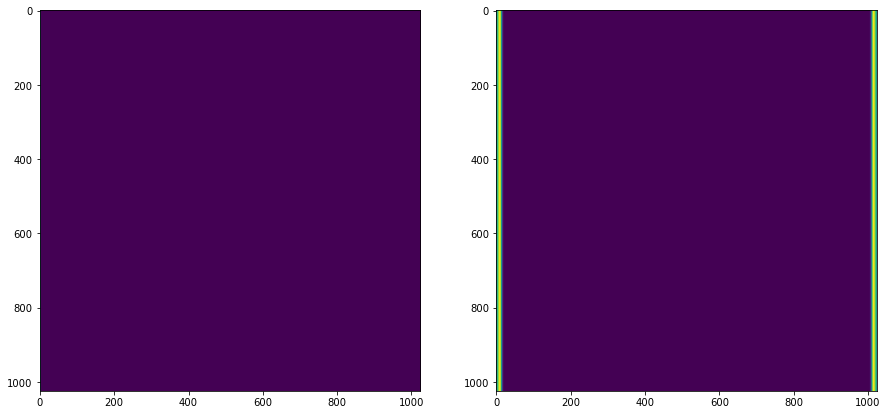

In [15]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize = (15,8))
ax[0].imshow(v)
ax[1].imshow(vf)
plt.show()

### Implementación paralela con Numba

In [53]:
from numba import njit,prange
import numpy as np

@njit(parallel = True)
def cpu_numba_parallel_solver(u, v, fu, fv, Ds, dt=.01, d = 1, it = 1000):
    '''
    Solve a 2D reaction-diffusion equation for two dynamical variables with periodic boundary conditions using Numba 
    with a parallel implementation.

    u: Intial conditions for the first dynamical variable. 2d NumPy array of shape (Ly,Lx).
    v: Intial conditions for the second dynamical variable. 2d NumPy array of shape (Ly,Lx).
    f1: Reaction term for the first dynamical variable. Function.
    f2: Reaction term for the second dynamical variable. Function.
    p1: Parameters for the f1 function.
    p2: Parameters for the f2 function.
    Ds: Diffusion coefficients for the first and second dynamical variables. List or array of length 2.
    dt: Time step. Default value is 0.01.
    d: Space step. Default value is 1.
    it: Number of iterations. Default value is 1000.
    '''    

    #Error checking
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")
    if len(Ds) != 2:
        raise ValueError("Ds must be a list or array of length 2.")

    Ly,Lx = u.shape
    u = u.reshape(Ly*Lx)
    v = v.reshape(Ly*Lx)
    Fu = np.zeros_like(u)
    Fv = np.zeros_like(v)
    Du,Dv = Ds
    for _ in range(it):
        for i in prange(Lx*Ly):
            x = i % Lx
            y = i // Lx
            laplacian_u = (u[(x+1)%Lx + Lx*y] + u[(x-1+Lx)%Lx+Lx*y] + u[x + Lx*((y+1)%Ly)] + u[x + Lx*((y-1+Ly)%Ly)] - 4*u[i])/d**2
            laplacian_v = (v[(x+1)%Lx + Lx*y] + v[(x-1+Lx)%Lx+Lx*y] + v[x + Lx*((y+1)%Ly)] + v[x + Lx*((y-1+Ly)%Ly)] - 4*v[i])/d**2
            Fu[i] = fu(u[i],v[i]) + Du*laplacian_u 
            Fv[i] = fv(u[i],v[i]) + Dv*laplacian_v
        u = u + dt*Fu
        v = v + dt*Fv
    return u.reshape(Ly,Lx),v.reshape(Ly,Lx)

In [54]:
@njit()
def fu(u,v):
    return -beta*u*v

@njit()
def fv(u,v):
    return beta*u*v - gamma*v

L = 1024
beta = 1
gamma = .2
u = np.ones((L,L))
v = np.zeros((L,L))
u[:,0] = 0
v[:,0] = 1
Ds = np.array([0,1])

uf,vf = cpu_numba_parallel_solver(u,v,fu,fv,Ds)

In [53]:
%timeit cpu_numba_parallel_solver(u,v,fu,fv,Ds)

6.31 s ± 439 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Implementación con CuPy

In [25]:
import cupy as cp


def cupy_laplacian(X):
    '''
    Take the Laplacian of a 2D array with periodic boundury conditions.
    '''
    return cp.roll(X,1,axis = 0) + cp.roll(X,-1,axis = 0) + cp.roll(X,1,axis = 1) + cp.roll(X,-1,axis = 1) - 4*X

def gpu_simple_cupy_solver(u, v, fu, fv, Ds, dt = .01, d = 1, it = 1000):
    '''
    Solve a 2D reaction-diffusion equation for two dynamical variables with periodic boundary conditions using NumPy.

    u: Intial conditions for the first dynamical variable. 2d NumPy array of shape (Ly,Lx).
    v: Intial conditions for the second dynamical variable. 2d NumPy array of shape (Ly,Lx).
    fu: Reaction term for the first dynamical variable. Function.
    fv: Reaction term for the second dynamical variable. Function.
    Ds: Diffusion coefficients for the first and second dynamical variables. List or array of length 2.
    dt: Time step. Default value is 0.01.
    d: Space step. Default value is 1.
    it: Number of iterations. Default value is 1000.
    '''
    
    #Error checking
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")
    if len(Ds) != 2:
        raise ValueError("Ds must be a list or array of length 2.")
    
    Du,Dv = Ds
    for _ in range(it):
        u = u + dt*(fu(u,v) + Du*cupy_laplacian(u)/d**2)
        v = v + dt*(fv(u,v) + Dv*cupy_laplacian(v)/d**2)
    return u,v

In [26]:
def fu(u,v):
    return -beta*u*v

def fv(u,v):
    return beta*u*v - gamma*v

L = 1024
beta = 1
gamma = .2
u = cp.ones((L,L))
v = cp.zeros((L,L))
u[:,0] = 0
v[:,0] = 1
Ds = [0,1]

uf,vf = gpu_simple_cupy_solver(u,v,fu,fv,Ds)

In [10]:
%timeit gpu_simple_cupy_solver(u,v,fu,fv,Ds)

3.41 s ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1]:
import cupy as cp
def mul_add(A,B,C):
    return A*B + C

L = 1024
A = cp.ones((L,L))
B = cp.ones((L,L))
C = cp.ones((L,L))
mul_add(A,B,C)
%timeit mul_add(A,B,C)

217 µs ± 834 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [311]:
import cupy as cp
mul_add_kernel = cp.ElementwiseKernel(
    'float64 A, float64 B, float64 C', 'float64 out',
    'out = A*B + C', 'mul_add')

L = 1024
A = cp.ones((L,L))
B = cp.ones((L,L))
C = cp.ones((L,L))
mul_add_kernel(A,B,C)
%timeit mul_add_kernel(A,B,C)

136 µs ± 273 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [45]:
import cupy as cp
forces = cp.ElementwiseKernel(
    'raw float64 u, raw float64 v, float64 beta, float64 gamma, float64 Du, float64 Dv, uint32 Lx, uint32 Ly',
    'float64 Fu, float64 Fv',
    '''
    int x = i % Lx;
    int y = (int) i / Lx;
    Fu = - beta * u[i] * v[i] + Du * (u[(x+1)%Lx + Lx*y] + u[(x-1+Lx)%Lx + Lx*y] + u[x + Lx*((y+1)%Ly)] + u[x + Lx*((y-1+Ly)%Ly)] - 4 * u[i]);
    Fv = beta * u[i] * v[i] - gamma * v[i] + Dv * (v[(x+1)%Lx + Lx*y] + v[(x-1+Lx)%Lx+Lx*y] + v[x + Lx*((y+1)%Ly)] + v[x + Lx*((y-1+Ly)%Ly)] - 4 * v[i]);
    ''',
    'forces', options = ('--use_fast_math',))

euler = cp.ElementwiseKernel(
    'float64 Fu, float64 Fv, float64 dt','float64 u, float64 v',
    '''
    u = u + dt*Fu;
    v = v + dt*Fv;
    ''',
    'euler')

def gpu_cupy_solver(u, v, Ds, beta = 1.,gamma = .2, dt = .01, d = 1, it = 1000):
    '''
    Solve a 2D reaction-diffusion equation for two dynamical variables with periodic boundary conditions using CuPy.

    u: Intial conditions for the first dynamical variable. 2d CuPy array of shape (Ly,Lx).
    v: Intial conditions for the second dynamical variable. 2d CuPy array of shape (Ly,Lx).
    Ds: Diffusion coefficients for the first and second dynamical variables. List or array of length 2.
    dt: Time step. Default value is 0.01.
    d: Space step. Default value is 1.
    it: Number of iterations. Default value is 1000.
    '''
    
    #Error checking
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")
    if len(Ds) != 2:
        raise ValueError("Ds must be a list or array of length 2.")
        
    Ly,Lx = u.shape
    Du,Dv = Ds
    Fu = cp.zeros_like(u)
    Fv = cp.zeros_like(v)

    for _ in range(it):
        forces(u,v,beta,gamma,Du,Dv,Lx,Ly,Fu,Fv)
        euler(Fu,Fv,dt,u,v)
    return u,v

In [47]:
L = 1024
u = cp.ones((L,L))
v = cp.zeros((L,L))
u[:,0] = 0
v[:,0] = 1
Ds = [0.,1.]
gpu_cupy_solver(u,v,Ds,it=1000)

(array([[0.        , 0.03628753, 0.03965281, ..., 0.04524237, 0.03965281,
         0.03628753],
        [0.        , 0.03628753, 0.03965281, ..., 0.04524237, 0.03965281,
         0.03628753],
        [0.        , 0.03628753, 0.03965281, ..., 0.04524237, 0.03965281,
         0.03628753],
        ...,
        [0.        , 0.03628753, 0.03965281, ..., 0.04524237, 0.03965281,
         0.03628753],
        [0.        , 0.03628753, 0.03965281, ..., 0.04524237, 0.03965281,
         0.03628753],
        [0.        , 0.03628753, 0.03965281, ..., 0.04524237, 0.03965281,
         0.03628753]]),
 array([[0.2454542 , 0.25480389, 0.2729186 , ..., 0.29800704, 0.2729186 ,
         0.25480389],
        [0.2454542 , 0.25480389, 0.2729186 , ..., 0.29800704, 0.2729186 ,
         0.25480389],
        [0.2454542 , 0.25480389, 0.2729186 , ..., 0.29800704, 0.2729186 ,
         0.25480389],
        ...,
        [0.2454542 , 0.25480389, 0.2729186 , ..., 0.29800704, 0.2729186 ,
         0.25480389],
        [0.2

In [48]:
%timeit gpu_cupy_solver(u,v,Ds)

599 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
import cupy as cp

raw_forces = cp.RawKernel(r'''
extern "C" __global__
void my_forces(const double* u,const double* v, double* Fu, double* Fv, double beta, double gamma, double Du, double Dv, unsigned int Lx, unsigned int Ly) {
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;
    int idx = x + Lx * y;
    if (x < Lx && y < Ly){
        Fu[idx] = - beta * u[idx] * v[idx] + Du * (u[(x+1)%Lx + Lx*y] + u[(x-1+Lx)%Lx+Lx*y] + u[x + Lx*((y+1)%Ly)] + u[x + Lx*((y-1+Ly)%Ly)] - 4*u[idx]);
        Fv[idx] = beta * u[idx] * v[idx] - gamma * v[idx] + Dv * (v[(x+1)%Lx + Lx*y] + v[(x-1+Lx)%Lx+Lx*y] + v[x + Lx*((y+1)%Ly)] + v[x + Lx*((y-1+Ly)%Ly)] - 4*v[idx]);
    }
}
''', 'my_forces')

raw_euler = cp.RawKernel(r'''
extern "C" __global__
void my_euler(const double* Fu, const double* Fv, double* u, double* v, double dt, unsigned int Lx, unsigned int Ly) {
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;
    int idx = x + Lx * y;
    if (x < Lx && y < Ly){
        u[idx] = u[idx] + dt*Fu[idx];
        v[idx] = v[idx] + dt*Fv[idx];
    }
}
''', 'my_euler')

def gpu_raw_cupy_solver(u, v, Ds, beta = 1.,gamma = .2, dt = .01, d = 1, it = 1000):
    '''
    Solve a 2D reaction-diffusion equation for two dynamical variables with periodic boundary conditions using CuPy.

    u: Intial conditions for the first dynamical variable. 2d CuPy array of shape (Ly,Lx).
    v: Intial conditions for the second dynamical variable. 2d CuPy array of shape (Ly,Lx).
    Ds: Diffusion coefficients for the first and second dynamical variables. List or array of length 2.
    dt: Time step. Default value is 0.01.
    d: Space step. Default value is 1.
    it: Number of iterations. Default value is 1000.
    '''
    
    #Error checking
    if u.shape != v.shape:
        raise ValueError("u and v must have the same shape.")
    if len(Ds) != 2:
        raise ValueError("Ds must be a list or array of length 2.")
        
    Ly,Lx = u.shape
    Du,Dv = Ds
    Fu = cp.zeros_like(u)
    Fv = cp.zeros_like(v)
    threadsperblock = (16,8)
    blockspergrid = (Ly//threadsperblock[0],Lx//threadsperblock[1])
    for _ in range(it):
        raw_euler(blockspergrid,threadsperblock,(Fu,Fv,u,v,dt,Lx,Ly))
        raw_forces(blockspergrid,threadsperblock,(u,v,Fu,Fv,beta,gamma,Du,Dv,Lx,Ly))
    return u,v

In [31]:
L = 1024
u = cp.ones((L,L))
v = cp.zeros((L,L))
u[:,0] = 0
v[:,0] = 1
Ds = [0.,1.]
gpu_raw_cupy_solver(u,v,Ds,it=1000)

(array([[0.        , 0.03638035, 0.03976148, ..., 0.04537778, 0.03976148,
         0.03638035],
        [0.        , 0.03638035, 0.03976148, ..., 0.04537778, 0.03976148,
         0.03638035],
        [0.        , 0.03638035, 0.03976148, ..., 0.04537778, 0.03976148,
         0.03638035],
        ...,
        [0.        , 0.03638035, 0.03976148, ..., 0.04537778, 0.03976148,
         0.03638035],
        [0.        , 0.03638035, 0.03976148, ..., 0.04537778, 0.03976148,
         0.03638035],
        [0.        , 0.03638035, 0.03976148, ..., 0.04537778, 0.03976148,
         0.03638035]]),
 array([[0.24575821, 0.25513356, 0.27328673, ..., 0.29841824, 0.27328673,
         0.25513356],
        [0.24575821, 0.25513356, 0.27328673, ..., 0.29841824, 0.27328673,
         0.25513356],
        [0.24575821, 0.25513356, 0.27328673, ..., 0.29841824, 0.27328673,
         0.25513356],
        ...,
        [0.24575821, 0.25513356, 0.27328673, ..., 0.29841824, 0.27328673,
         0.25513356],
        [0.2

In [32]:
%timeit gpu_raw_cupy_solver(u,v,Ds)

599 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
